
# Prelims

In [ ]:
# IMPORT LIBRARIES #
from google.colab import drive

drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
# FOR USING R#
%reload_ext rpy2.ipython

In [ ]:
%%R
# FOR INSTALLING PACKAGES #
list.of.packages <- c("dplyr", "corrplot", 'expss','glmnet','pls','FNN','ggplot')

# Install packages if they are not already installed
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘iterators’, ‘htmlTable’, ‘matrixStats’, ‘foreach’, ‘shape’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/checkmate_2.0.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 168716 bytes (164 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]:

#Import Data

In [ ]:
%%R

data = read.csv('/content/drive/Shareddrives/Data Mining Project/Data/data.csv')
data_o = read.csv('/content/drive/Shareddrives/Data Mining Project/Data/data_o.csv')
data_w_genres = read.csv('/content/drive/Shareddrives/Data Mining Project/Data/data_w_genres.csv')

# Data Cleaning

## Remove weird stuff from artist titles and make into a list with multiple artists

In [ ]:
%%R
# Remove brackets within the string
temp = gsub(pattern = "(\\[)*(\\])*","",x= data$artists)
# Remove double quotation marks
temp = gsub(pattern = "(\")","",x= temp)
# Replace commas between artists with "NewArtistHere. This distinguishes between commas separating artists and commas within artist title"
temp = gsub(pattern = "',","'NewArtistHere",x= temp)
# Split each string on "NewArtistHere"
temp = strsplit(temp,"NewArtistHere")
# For each string, remove the single quotes that are around the string. This keeps intact any single quotes in artist name, such as Lil' Kim
temp = lapply(temp,function(x){gsub(pattern = "^ *\\'([a-zA-Z0-9 #@!&,;:_`\\?\\+\\*\\$\\.\\/\\(\\)\\-]*)\\' *$","\\1",x)})
# Attempt to remove single quotes around the names which are a bunch of random numbers. This is probably not worth it and needs fixing anyway. TODO: Possibly fix? 
data$artists_cleaned = lapply(temp,function(x){gsub(pattern = "^ *(.*[\303\317\346\331\303\304\320\305\316\345\350\327\343\342\340\302\351\354\\\\].*) *$","\\1",x)})

## Remove artist song duplicates conditioned on highest popularity score

In the double check below, I used song titles "Thriller" and "Hello" because there are multiple songs called Thriller (with many versions from MJ) and many songs called "Hello" by multiple artists (some with duplicates) so I wanted to use this small example to show that this method maintains songs of the same title, by different artists, with the highest popularity score.

In [ ]:
%%R
#used dplyr for 'duplicated' function

library(dplyr)

# create copy of data df
df <- data

# replace all duplicate artist songs with oldest value "date"
# print(df[df$name == "Thriller" & df$artists == "'Michael Jackson'",])

# order data frame by popularity, since 'duplicate' removes all duplicates of elements with higher index
df_ord <- df[order(df$popularity, decreasing = TRUE),]

#find oldest release date
print(head(df_ord[duplicated(df_ord[c("artists","name")]),]))

# remove any duplicates by artist(s) and song name
df_ord_dup <- df_ord[!duplicated(df_ord[c("artists","name")]),]

# rename df_ord_dup to data 
data <- df_ord_dup


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




      acousticness                      artists danceability duration_ms energy
20019      0.40100 ['Bad Bunny', 'Jhay Cortez']        0.731      205090  0.573
39343      0.01120                      ['BTS']        0.746      199054  0.765
93879      0.18500                   ['Maluma']        0.783      199112  0.727
58275      0.00883       ['Dua Lipa', 'DaBaby']        0.702      203064  0.825
58403      0.01230                 ['Dua Lipa']        0.793      183290  0.793
19755      0.60400            ['Lewis Capaldi']        0.459      215107  0.575
      explicit                     id instrumentalness key liveness loudness
20019        1 4MzXwWMhyBbmu6hOcLVD49         5.22e-05   4   0.1130  -10.059
39343        0 0t1kP63rueHleOhQkYSXFY         0.00e+00   6   0.0936   -4.410
93879        0 1yoMvmasuxZfqHEipJhRbp         2.46e-05   6   0.0626   -3.454
58275        0 5nujrmhLynf4yMoMtj8AQF         0.00e+00   6   0.0674   -3.787
58403        0 3PfIrDoz19wz7qK7tYeu62         0.00e+00 

In [ ]:
%%R
# make dates oldest year / date
# create a table that aggregates all the oldest dates by song and artist
minDate <- df %>% 
              group_by(name, artists) %>% 
              summarize(old_year = min(year), old_date = min(release_date))
#print(head(minDate))

# create an ordered data frame that also matches the order of the tibble so booleans are accurate
df_ord_dup1 <- df_ord_dup[order(df_ord_dup$name, df_ord_dup$artists),]

# reassign YEAR 
df_ord_dup1[(df_ord_dup1$name == minDate$name) & (df_ord_dup1$artists == minDate$artists),]$year <- minDate[(df_ord_dup1$name == minDate$name) & (df_ord_dup1$artists == minDate$artists),]$old_year

# reassign RELEASE_DATE
df_ord_dup1[(df_ord_dup1$name == minDate$name) & (df_ord_dup1$artists == minDate$artists),]$release_date <- minDate[(df_ord_dup1$name == minDate$name) & (df_ord_dup1$artists == minDate$artists),]$old_date

# double check it replaced using Thriller
# print(df[(df$name == "Thriller" & df$artists_cleaned == "Michael Jackson"),])
# print(df_ord_dup1[(df_ord_dup1$name == "Thriller" & df_ord_dup1$artists_cleaned == "Michael Jackson"),])

# rename df_ord_dup to data 
data <- df_ord_dup1

`summarise()` has grouped output by 'name'. You can override using the `.groups` argument.


## Create 'exist years' column

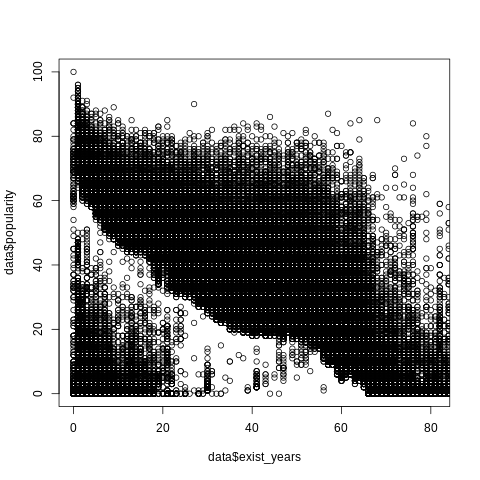

In [ ]:
# Create exist years as the number of years that a song has existed
%%R
data$exist_years = 2021-data$year
plot(data$exist_years,data$popularity,xlim = c(0,81), ylim = c(0,100))


## Null values

In [ ]:
%%R

#lapply(data,function(x) { length(which(is.na(x)))})

NULL


Seems like we dont have null values?!?!

## Clean Genre column and add to data

In [ ]:
%%R

newdf <- data_w_genres[,c("artists", "genres")]

names = list("adult_standard", "alternative", "blues", "classical", "country", "dance", "electronic", "hiphop", "indie",
         "jazz", "latin", "pop", "rap", "rb", "soul", "rock", "showtunes", "other", "missing")

for (i in names){
    #print(i)
    newdf[i] <- 0 
}

In [ ]:
%%R

newdf[grep(".*adult_standard.*|.*lounge.*|.*contemporary.*|.*guitar.*|.*ambient.*|.*easy listening.*", newdf$genres),]$adult_standard = 1
newdf[grep(".*alternative.* |.*trance.*", newdf$genres),]$alternative = 1
newdf[grep(".*blues.*", newdf$genres),]$blues = 1
newdf[grep(".*classical.*|.*composition.*|.*choral.*|.*soundtrack.*|.*piano.*|.*accordion.*|.*opera.*|.*baroque.*|.*renaissance.*", newdf$genres),]$classical = 1
newdf[grep(".*country.*|.*folk.*|.*americana.*|.*bluegrass.*|.*swing.*|.*stomp.*|.*banjo.*|.*red dirt.*|.*appalachhian.*", newdf$genres),]$country = 1
newdf[grep(".*dance.*|.*disco.*|.*funk.*", newdf$genres),]$dance = 1
newdf[grep(".*electronic.*|.*techno.*|.*edm.*|.*house.*|.*bass.*|.*rave.*|.*wave.*|.*dubstep.*|.*electro.*", newdf$genres),]$electronic = 1
newdf[grep(".*hip hop.*|.*hip-hop.*", newdf$genres),]$hiphop = 1
newdf[grep(".*indie.*|.*lofi.*|.*lo-fi.*", newdf$genres),]$indie = 1
newdf[grep(".*jazz.*|.*bebop.*", newdf$genres),]$jazz = 1
newdf[grep(".*latin.*|.*salsa.*|.*bachata.*|.*banda.*|.*mariachi.*|.*bolero.*|.*tango.*|.*ranchera.*|.*reggaeton.*|.*rumba.*|.*samba.*|.*cumbia.*|.*cubano.*|.*musica.*|.*mambo.*|.*mexico.*", newdf$genres),]$latin = 1
newdf[grep(".*pop.*|.*boy-band.*|.*boyband.*|.*boy band.*|.*opm.*|.*girl-group.*|.*girlgroup.*|.*girl group.*", newdf$genres),]$pop = 1
newdf[grep(".*rap.*|.*trap.*", newdf$genres),]$rap = 1
newdf[grep(".*r\u0026b.*", newdf$genres),]$rb = 1
newdf[grep(".*soul.*|.*gospel.*", newdf$genres),]$soul = 1
newdf[grep(".*rock.*|.*punk.*|.*metal.*|.*grunge.*|.*christian.*|.*psychedelic.*|.*worship.*", newdf$genres),]$rock = 1
newdf[grep(".*show tunes.*|.*disney.*|.*choir.*|.*broadway.*|.*movie.*", newdf$genres),]$showtunes = 1
newdf[newdf$genres == "[]",]$missing = 1
newdf$other = as.integer(rowSums(subset(newdf, select = -c(artists,genres))) == 0)

In [ ]:
%%R

genreSums <- colSums(subset(newdf, select = -c(artists,genres)))
print(sort(genreSums, decreasing =TRUE))

print(sort(genreSums / (nrow(newdf)-sum(newdf$missing)), decreasing = TRUE))

dim(newdf)

       missing            pop           rock          other     electronic 
         13563           5238           4778           2737           2507 
       country          dance    alternative      classical            rap 
          2390           2166           1945           1842           1742 
         indie          latin adult_standard         hiphop           jazz 
          1454           1424           1401           1307           1208 
          soul          blues             rb      showtunes 
          1120            664            481            428 
       missing            pop           rock          other     electronic 
    0.71474494     0.27603288     0.25179174     0.14423482     0.13211425 
       country          dance    alternative      classical            rap 
    0.12594857     0.11414418     0.10249789     0.09706998     0.09180017 
         indie          latin adult_standard         hiphop           jazz 
    0.07662310     0.07504216     0.073830

R[write to console]: corrplot 0.84 loaded



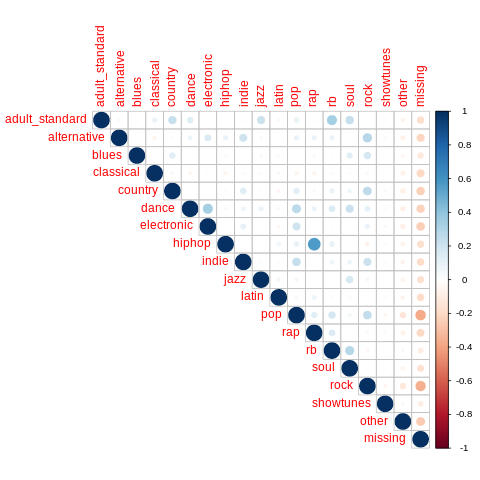

In [ ]:
%%R
library("corrplot")
corrplot(cor(subset(newdf, select = -c(artists,genres))),type = "upper")

In [ ]:
%%R

genre_consol <- data_w_genres[,c("artists", "genres")]

# consolodating columns
genre_consol$hiphop_rap <- as.integer(newdf$hiphop + newdf$rap > 0)
genre_consol$electro_dance <- as.integer(newdf$dance + newdf$electronic > 0)
genre_consol$jazz <- as.integer(newdf$adult_standard + newdf$soul + newdf$rb + newdf$jazz > 0)
genre_consol$alternative <- as.integer(newdf$indie + newdf$alternative > 0)
genre_consol$rock <- as.integer(newdf$rock + newdf$blues > 0)
genre_consol$other <- as.integer(newdf$showtunes + newdf$other > 0)

# adding columns
genre_consol$pop <- newdf$pop
genre_consol$country <- newdf$country
genre_consol$classical <- newdf$classical
genre_consol$latin <- newdf$latin
genre_consol$missing <- newdf$missing

summy <- colSums(genre_consol[,-c(1,2)])

print(sort(summy, decreasing = TRUE))
cat("\n\n")
print(sort(summy/nrow(genre_consol), decreasing = TRUE))

      missing           pop          rock electro_dance         other 
        13563          5238          5063          3780          3165 
         jazz   alternative       country    hiphop_rap     classical 
         3074          2981          2390          2173          1842 
        latin 
         1424 


      missing           pop          rock electro_dance         other 
   0.41682289    0.16097606    0.15559790    0.11616829    0.09726789 
         jazz   alternative       country    hiphop_rap     classical 
   0.09447125    0.09161314    0.07345032    0.06678140    0.05660899 
        latin 
   0.04376287 


In [ ]:
%%R 
library(tidyr)
library(dplyr)
library('expss')

#rm(merged_df)
newdata <- data

#Unlisting artists_cleaned and separating each artists by ";: "
newdata$artists_unlist<- sapply(newdata$artists_cleaned, function(y) paste(unlist(y), collapse = ";: "))

#Separating rows based on ;: in artists_unlist column and copying all other information
newdata <- separate_rows(newdata, artists_unlist, sep = ";: ")

#Looking up genre from data_w_genres 
temp <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','genres')], 
        lookup_column = 'artists'))

newdata$hiphop_rap <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','hiphop_rap')], 
        lookup_column = 'artists'))$hiphop_rap

newdata$electro_dance <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','electro_dance')], 
        lookup_column = 'artists'))$electro_dance

newdata$jazz <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','jazz')], 
        lookup_column = 'artists'))$jazz

newdata$alternative <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','alternative')], 
        lookup_column = 'artists'))$alternative

newdata$rock <- (vlookup_df(lookup_value = newdata$artists_unlist, 
      dict = genre_consol[,c('artists','rock')], 
      lookup_column = 'artists'))$rock

newdata$other <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','other')], 
        lookup_column = 'artists'))$other

newdata$pop <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','pop')], 
        lookup_column = 'artists'))$pop

newdata$country <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','country')], 
        lookup_column = 'artists'))$country

newdata$classical <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','classical')], 
        lookup_column = 'artists'))$classical


newdata$latin <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','latin')], 
        lookup_column = 'artists'))$latin

newdata$missing <- (vlookup_df(lookup_value = newdata$artists_unlist, 
        dict = genre_consol[,c('artists','missing')], 
        lookup_column = 'artists'))$missing

newdata$genres <- temp$genres

newdata <- as.data.frame(newdata)

# Merging the separated rows together based on their id and creating new variable genres1
temp1 <- newdata %>% 
              group_by(id) %>% 
              mutate(genres_combined = paste0(genres, collapse =", "), 
                     pop = as.integer(sum(pop) > 0)) #genres1 is a combination of genres if they have same id

temp1$artists_unlist <- NULL
temp1$genres <- NULL


merged_df <- temp1 %>%
                group_by(id)
                merged_df <- as.data.frame(merged_df)

#Removing duplicate rows 
merged_df <- merged_df[!duplicated(merged_df$id),]

merged_df[1:10,c('id', 'artists_cleaned','genres_combined')]

print(dim(merged_df))
print(dim(data))

#Changing NA values to 1 in merged_df for regression
merged_df$missing[is.na(merged_df$missing)] <- 1

#Chanign all other NA to 0 for regression
merged_df[is.na(merged_df)] = 0

R[write to console]: 
Attaching package: ‘expss’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    contains, nest


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, compute, contains, first, last, na_if, recode, vars




[1] 159441     33
[1] 159441     21


In [ ]:
%%R
# Check that everything is working how we expect
stuckwyou = 39249
print(head(data_w_genres[data_w_genres$artists == 'Ariana Grande',"genres"]))
print(head(data_w_genres[data_w_genres$artists == 'Justin Bieber',"genres"]))

str(merged_df[merged_df$name == 'Stuck with U (with Justin Bieber)',"genres_combined"])
merged_df[merged_df$name == 'Stuck with U (with Justin Bieber)',]

head(merged_df)

[1] "['dance pop', 'pop', 'post-teen pop']"
[1] "['canadian pop', 'pop', 'post-teen pop']"
 chr "['dance pop', 'pop', 'post-teen pop'], ['canadian pop', 'pop', 'post-teen pop']"
  acousticness                  artists danceability duration_ms energy
1        0.194         ['Apocolothoth']       0.0794      132962  0.378
2        0.755 ['אומן האור ומלך הסבון']       0.6410       22240  0.264
3        0.604           ['Raúl Abríl']       0.6320      154680  0.352
4        0.433         ['Juan Gabriel']       0.4200      198773  0.251
5        0.527         ['Bonny Cepeda']       0.7710      304627  0.800
6        0.752       ['Joan Sebastian']       0.7440      177969  0.545
  explicit                     id instrumentalness key liveness loudness mode
1        0 3hBa6dhSHREIInLD13ilX9           0.8460   7   0.1000  -12.947    1
2        0 3bRCavbJb8oFFd6ixjil73           0.9930   3   0.5050  -22.449    1
3        0 1RnXmFzzV04OWmY9a2aMhe           0.0000   5   0.3710  -16.204    1
4     

In [ ]:
%%R
# GET ALL UNIQUE GENRES
# Remove brackets within the string
temp = gsub(pattern = "(\\[)*(\\])*","",x= data_w_genres$genres)
# Remove double quotation marks
temp = gsub(pattern = "(\")","",x= temp)
temp = gsub(pattern = "'","",x= temp)
# Split each string on "NewArtistHere"
temp = strsplit(temp,", ")

all = c()
for (entry in temp) {
    all = c(all, entry)
}

## Split groups
Split the data into under and above that weird artifact

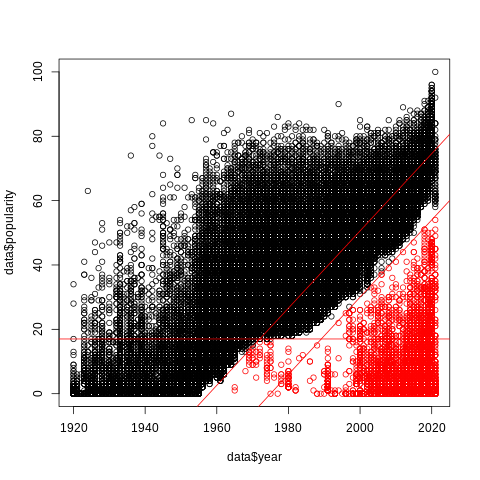

In [ ]:
%%R
# Separate the data into groups
m1 = 1.2
m2 = 1.2
horizontal = 17
intercept1 = 54 - m1*2020
intercept2 = horizontal - m2*1972

in_group3 = (data$year*m2 + intercept2 > data$popularity & data$year > -intercept2/m2 & data$year <= 1972) | 
            (data$year*m1 + intercept1 > data$popularity & data$year > (horizontal - intercept1)/m1) | 
            (data$popularity < horizontal & data$year >= (horizontal-intercept2)/m2)

plot(data$year, data$popularity, col= ifelse(in_group3, "red","black"))
abline(a = intercept1, b = m1, col = "red")
abline(a = intercept2, b = m2, col = "red")
abline(h = horizontal, col = "red")

# Descriptive Statistics

## Exploring difference between the two groups

In [ ]:
%%R
above = merged_df[!in_group3,]
below = merged_df[in_group3,]

colnames(above)
genre_sums = colSums(subset(above, select = c(hiphop_rap,electro_dance,jazz,alternative,rock,other,pop,country,classical,latin,missing)))

head(genre_sums)

   hiphop_rap electro_dance          jazz   alternative          rock 
        10109         22990         30746         11458         49442 
        other 
         9375 


## Exploring top 5 popular genres through different years



In [ ]:
%%R
new_genres <- c('hiphop_rap','electro_dance', 'jazz', 'alternative', 'rock', 'other', 'pop', 'country','classical', 'latin','missing')

In [ ]:
%%R

byPopularity <- merged_df %>% group_by(year)

byPopularity <- byPopularity %>% 
                arrange(desc(popularity)) %>%
                slice(1:5)
byPopularity <- (subset(byPopularity, select = c(year, hiphop_rap,electro_dance,jazz,alternative,rock,other,pop,country,classical,latin,missing)))

byPopularity <- byPopularity %>%
  group_by(year) %>%
  mutate_each(funs(an = as.numeric(as.character(.)))) %>%
  gather(popularGenre, val, -year) %>%
  filter(val == 1) %>%
  select(-val) %>%
  arrange(year)

byPopularity <- byPopularity %>%
                group_by(year) %>%
                summarise(popularGenre = list(unique(popularGenre)))
class(byPopularity)
head(as.data.frame(byPopularity),5)

  year
1 1920
2 1921
3 1922
4 1923
5 1924
                                                                                                      popularGenre
1 jazz, rock, other, country, classical, missing, jazz_an, rock_an, other_an, country_an, classical_an, missing_an
2                                                                     classical, missing, classical_an, missing_an
3                                                                             other, missing, other_an, missing_an
4                                       jazz, rock, country, classical, jazz_an, rock_an, country_an, classical_an
5                  jazz, rock, country, classical, missing, jazz_an, rock_an, country_an, classical_an, missing_an


## Word cloud based on top 5 popular genres

In [ ]:
%%R
# Install
install.packages("tm")  # for text mining
install.packages("SnowballC") # for text stemming
install.packages("wordcloud") # word-cloud generator 
install.packages("RColorBrewer") # color palettes
# Load
library("tm")
library("SnowballC")
library("wordcloud")
library("RColorBrewer")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘NLP’, ‘slam’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/NLP_0.2-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 144368 bytes (140 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

In [ ]:
%%R
listgenre <- as.data.frame(byPopularity)[,2]
unlistgenre <- paste(unlist(listgenre),collapse=' ')
docs <- Corpus(VectorSource(unlistgenre))
toSpace <- content_transformer(function (x , pattern ) gsub(pattern, " ", x))
docs <- tm_map(docs, toSpace, "_an")
inspect(docs)
dtm <- TermDocumentMatrix(docs)
m <- as.matrix(dtm)
v <- sort(rowSums(m),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)
head(d, 10)

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 1

[1] jazz rock other country classical missing jazz  rock  other  country  classical  missing  classical missing classical  missing  other missing other  missing  jazz rock country classical jazz  rock  country  classical  jazz rock country classical missing jazz  rock  country  classical  missing  jazz country classical jazz  country  classical  jazz country classical missing jazz  country  classical  missing  jazz rock country jazz  rock  country  jazz rock pop country classical jazz  rock  pop  country  classical  jazz rock country classical missing jazz  rock  country  classical  missing  classical latin missing classical  latin  missing  country latin missing country  latin  missing  jazz pop country classical jazz  pop  country  classical  jazz rock country classical jazz  rock  country  classical  other classical missing other  classical  missing  jazz country classical jazz  count

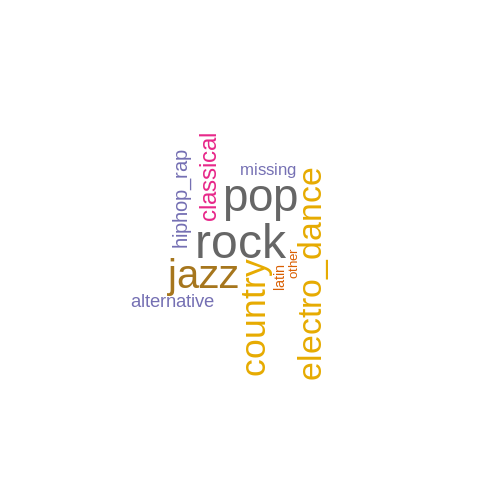

In [ ]:
%%R
set.seed(1234)
wordcloud(words = d$word, freq = d$freq, min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

# Regression to predict popularity

## Functions

### Test/train split function

In [ ]:
%%R
test_train_split = function(data) {
  # Create test/train split    
  set.seed(1234)
  randoms = runif(nrow(data))

  data_test = data[randoms > .8,]
  data_train = data[randoms <= .8,] 
  X_train = as.matrix(subset(data_train, select = -c(popularity, id, name, release_date,artists,artists_cleaned,year)))
  y_train = as.matrix(data_train$popularity)
  X_test = as.matrix(subset(data_test, select = -c(popularity, id, name, release_date,artists,artists_cleaned,year)))
  y_test = as.matrix(data_test$popularity)

  split = list(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)
}

### Function for running LASSO/ridge/pcr and displaying results

In [ ]:
%%R
library(glmnet)
library(pls)

run_regressions = function(X_train, y_train, X_test, y_test, lam_seq) {
    ## This will run the different models we want to run on each group. TODO: add PCR, and figure out why ridge/lasso/enet
    ## are giving very similar MSEs and prediction plots##

# Run regression
fit_lm = glmnet(x=X_train,y=y_train,family="gaussian",alpha=0,lambda=0)
predict_lm = predict(fit_lm, X_test)
RMSE_lm = sqrt(mean((predict_lm - y_test)^2))

# Run ridge
fit_cv.ridge = suppressWarnings(cv.glmnet(x=X_train,y=y_train,family="gaussian",alpha=0, lambda = lam_seq))
fit_ridge = glmnet(x=X_train,y=y_train,family="gaussian",alpha=0,lambda=fit_cv.ridge$lambda.min)
predict_ridge = predict(fit_ridge,X_test)
RMSE_ridge = sqrt(mean((predict_ridge - y_test)^2))

# Run Enet
fit_cv.enet = suppressWarnings(cv.glmnet(x=X_train,y=y_train,family="gaussian",alpha=0.5, lambda = lam_seq))
fit_enet = glmnet(x=X_train,y=y_train,family="gaussian",alpha=0,lambda=fit_cv.enet$lambda.min)
predict_enet = predict(fit_enet,X_test)
RMSE_enet = sqrt(mean((predict_enet - y_test)^2))


# Run LASSO
fit_cv.lasso = suppressWarnings(cv.glmnet(x=X_train,y=y_train,family="gaussian",alpha=1, lambda = lam_seq))
fit_lasso = glmnet(x=X_train,y=y_train,family="gaussian",alpha=0,lambda=fit_cv.lasso$lambda.min)
predict_lasso = predict(fit_lasso,X_test)
RMSE_lasso = sqrt(mean((predict_lasso - y_test)^2))

# Run PCR
X_train_scaled = scale(X_train, center =TRUE, scale = TRUE)
X_test_scaled = scale(X_test, center =TRUE, scale = TRUE)
vars = svd(X_train_scaled)$d^2
n_comps = min(which(cumsum(vars/sum(vars)) > 0.8))
print(n_comps)

fit_pcr = pcr(y_train~X_train_scaled,ncomp=n_comps)
predict_pcr = predict(fit_pcr, newdata = X_test_scaled,ncomp = n_comps)[,,1]
RMSE_pcr = sqrt(mean((predict_pcr - y_test)^2))

par(mfrow=c(2,2))
plot(y_test,predict_ridge, main = "Ridge Predictions")
plot(y_test,predict_enet, main = "Elastic Net Predictions")
plot(y_test,predict_lasso, main = "LASSO Predictions")
plot(y_test,predict_pcr, main = "PCR Predictions")

par(mfrow=c(1,1))
my_bar = barplot(c(RMSE_lm,RMSE_ridge, RMSE_enet, RMSE_lasso, RMSE_pcr), names.arg = c("LM","Ridge", "Enet", 'Lasso', 'PCR'), ylab = 'Test RMSE')
text(my_bar, c(RMSE_lm,RMSE_ridge, RMSE_enet, RMSE_lasso, RMSE_pcr)-.4 , paste(round(c(RMSE_lm,RMSE_ridge, RMSE_enet, RMSE_lasso, RMSE_pcr),2)) ,cex=1) 

fits = list("lm" = fit_lm, "ridge" = fit_ridge, "enet" = fit_enet, "lasso" = fit_lasso, "pcr"=fit_pcr)
RMSEs = list("lm" = RMSE_lm, "ridge" = RMSE_ridge, "enet" = RMSE_enet, "lasso" = RMSE_lasso, "pcr"=RMSE_pcr)

results = list('fits' = fits, 'RMSEs' = RMSEs)
}


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Loaded glmnet 4.1-1

R[write to console]: 
Attaching package: ‘pls’


R[write to console]: The following object is masked from ‘package:corrplot’:

    corrplot


R[write to console]: The following object is masked from ‘package:stats’:

    loadings




### Function for running KNN and displaying 

In [ ]:
%%R
library(FNN)

run_knn = function(X_train, y_train, X_test, y_test, Ks) {
    
  # Remove exist years
  #exist_years_index = which(dimnames(splits_5$X_train)[[2]] == 'exist_years')
    
  # Create validation set to find best k, remove exist years
  randoms = runif(nrow(X_train))
  validation = .8
  X_train_knn = X_train[randoms <= validation,]
  y_train_knn = y_train[randoms <= validation]
  X_validate = X_train[randoms > validation,]
  y_validate = y_train[randoms > validation]

  RSSs = c()
  for (k_val in Ks) {
    knn_model = knn.reg(train = X_train_knn, y = y_train_knn, test = X_validate, k = k_val)
    rss = sum((knn_model$pred - y_validate)^2)
    RSSs = append(RSSs, rss)
    }

  # Select k with lowest RSS
  plot(Ks, RSSs)
  best_k = Ks[which(RSSs == min(RSSs))]
  print(best_k)

  # Run full model with selected k
  full_knn_model = knn.reg(train = X_train, y = y_train, test = X_test, k = best_k)
  RMSE = sqrt(mean((full_knn_model$pred - y_test)^2))
  print(RMSE)
  plot(y_test,full_knn_model$pred)

}

## Run regressions on different groups

### Group 1: Entire data

In [ ]:
%%R
# Create splits
splits = test_train_split(data)
splits_genre = test_train_split(subset(merged_df, select = -c(genres_combined)))
bl = sqrt(mean((mean(data$popularity) - splits$y_test)^2))
paste("Baseline RMSE for predicting popularity at the average is ", bl)

[1] "Baseline RMSE for predicting popularity at the average is  22.0017091254512"


[1] 8
[1] 15


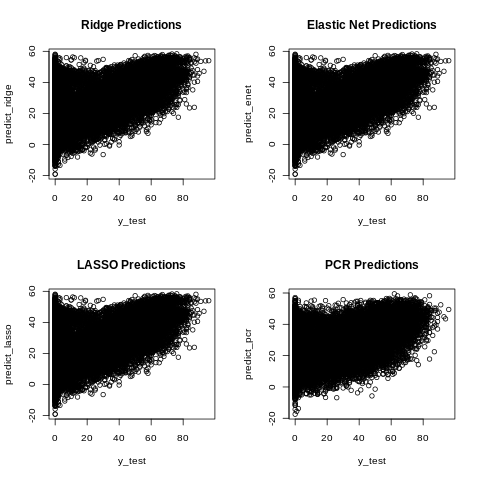

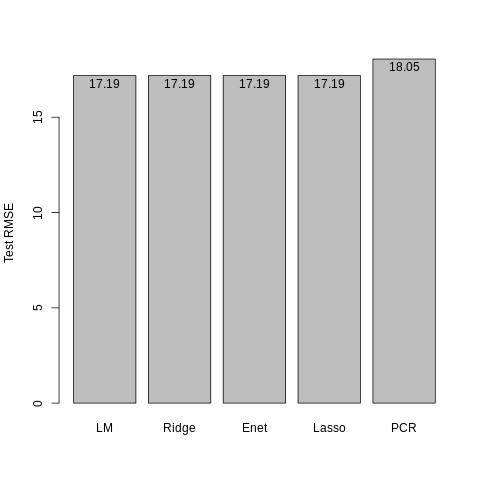

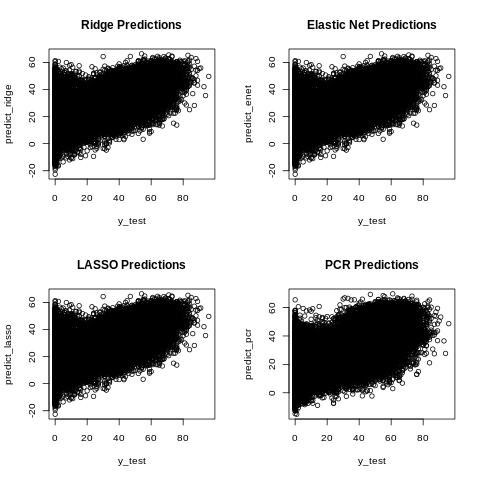

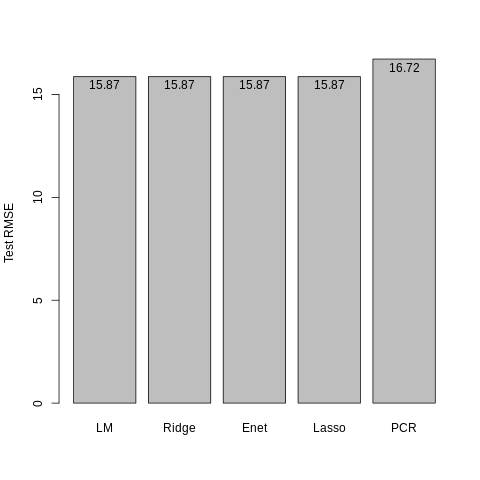

In [ ]:
%%R

# Run LASSO, enet, ridge and PCR
lam_seq = 10^seq(-10,10,length.out =100)
results1 = run_regressions(splits$X_train, splits$y_train, splits$X_test, splits$y_test, lam_seq)
results1_genre = run_regressions(splits_genre$X_train, splits_genre$y_train, splits_genre$X_test, splits_genre$y_test, lam_seq)

In [ ]:
%%R
barplot(fits$ridge$beta[1:14], names.arg = rownames(fits$ridge$beta), las =2)
barplot(fits$enet$beta[1:14], names.arg = rownames(fits$enet$beta), las =2)
barplot(fits$lasso$beta[1:14], names.arg = rownames(fits$lasso$beta), las =2)

print(fits$ridge$beta)
print(fits$lasso$beta)

R[write to console]: Error in barplot(fits$ridge$beta[1:14], names.arg = rownames(fits$ridge$beta),  : 
  object 'fits' not found

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package ‘ggplot’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages 




Error in barplot(fits$ridge$beta[1:14], names.arg = rownames(fits$ridge$beta),  : 
  object 'fits' not found


[1] 15
[1] 18.46774
[1] 15
[1] 18.4669


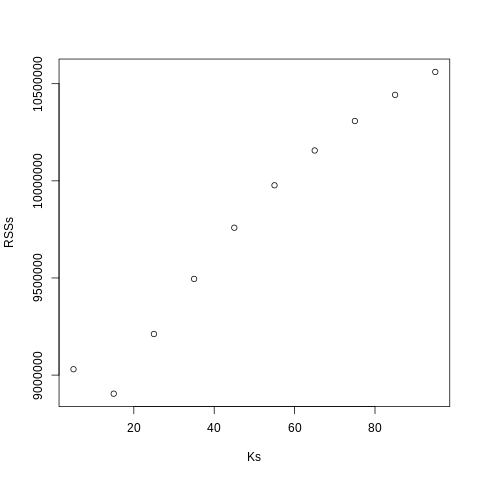

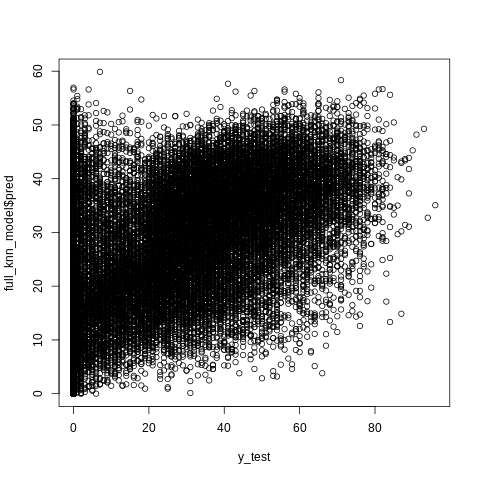

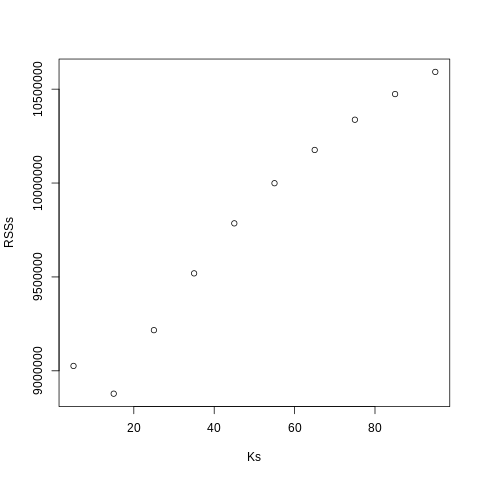

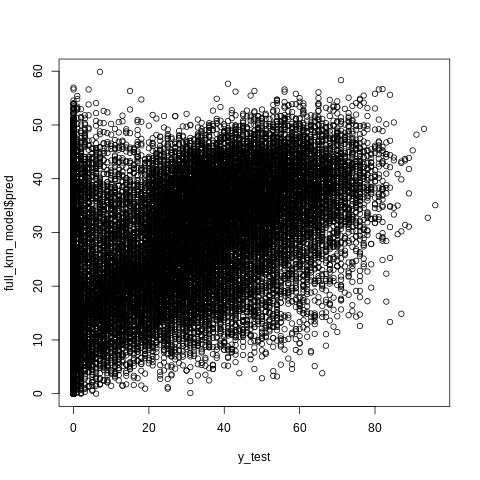

In [ ]:
%%R
# Run KNN
Ks = seq(5,100,10)
run_knn(splits$X_train, splits$y_train, splits$X_test, splits$y_test, Ks)
run_knn(splits_genre$X_train, splits_genre$y_train, splits_genre$X_test, splits_genre$y_test, Ks)

###Group 2: Above Red Line

In [ ]:
%%R
data_group2 = data[!in_group3,]
data_group2_genre = merged_df[!in_group3,]
splits_2 = test_train_split(data_group2)
splits_2_genre = test_train_split(subset(data_group2_genre, select = -c(genres_combined)))
b2 = sqrt(mean((mean(data_group2$popularity) - splits_2$y_test)^2))
paste("Baseline RMSE for predicting popularity at the average is ", b2)

[1] "Baseline RMSE for predicting popularity at the average is  21.7628037846486"


[1] 8
[1] 14


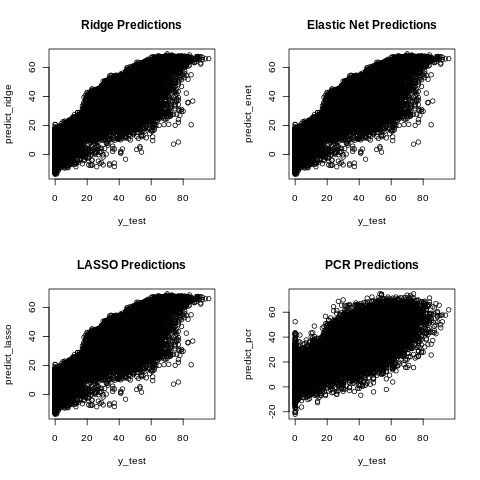

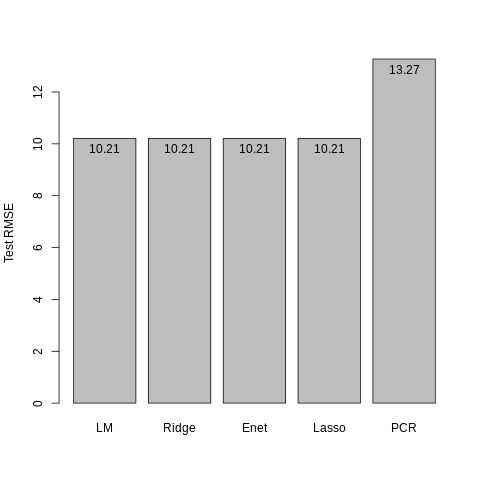

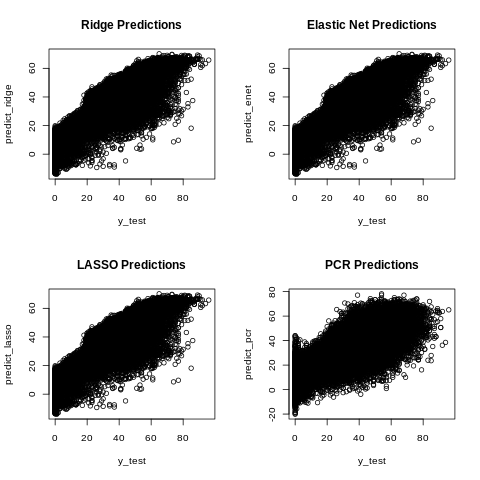

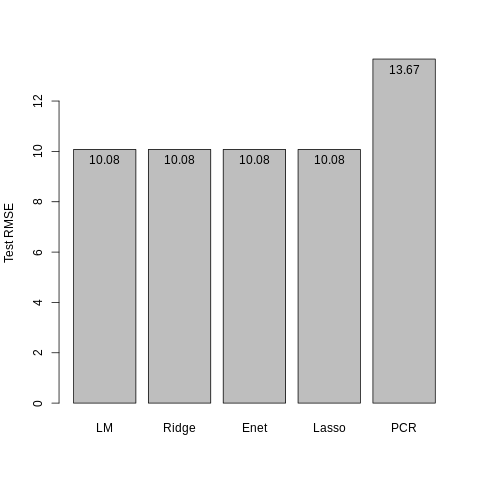

In [ ]:
%%R
lam_seq = 10^seq(-10,10,length.out =100)
results2 = run_regressions(splits_2$X_train, splits_2$y_train, splits_2$X_test, splits_2$y_test, lam_seq)
results2_genre = run_regressions(splits_2_genre$X_train, splits_2_genre$y_train, splits_2_genre$X_test, splits_2_genre$y_test, lam_seq)

In [ ]:
%%R
print(results2$fits$lm$beta)
print(results2_genre$fits$lm$beta)

14 x 1 sparse Matrix of class "dgCMatrix"
                            s0
acousticness     -3.927922e+00
danceability      5.461116e+00
duration_ms      -8.905242e-07
energy           -1.295441e+00
explicit         -5.765521e-02
instrumentalness -2.814782e+00
key              -7.888375e-04
liveness         -3.145849e+00
loudness          1.022786e-01
mode             -2.945681e-01
speechiness      -5.707766e+00
tempo             5.917722e-03
valence          -1.513273e+00
exist_years      -7.092582e-01
25 x 1 sparse Matrix of class "dgCMatrix"
                            s0
acousticness     -3.007281e+00
danceability      4.860348e+00
duration_ms      -9.103039e-07
energy           -1.603048e+00
explicit          8.661184e-01
instrumentalness -1.852261e+00
key               8.973745e-04
liveness         -3.213058e+00
loudness          8.879457e-02
mode             -2.997038e-01
speechiness      -3.331656e+00
tempo             3.198734e-03
valence          -1.908661e+00
exist_years      

[1] 5
[1] 14.31451


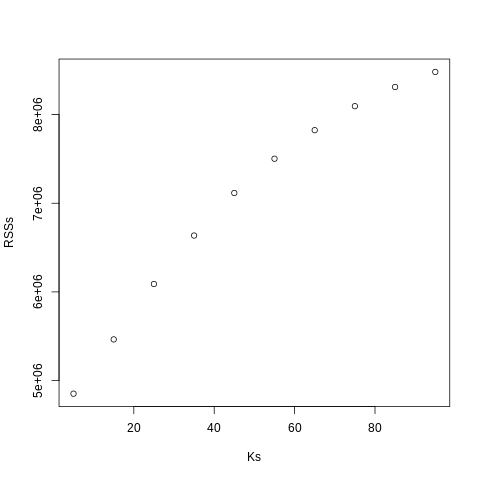

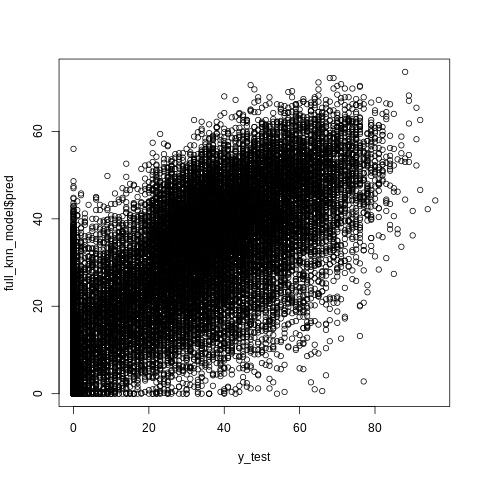

In [ ]:
%%R
# Run KNN
Ks = seq(5,100,10)
run_knn(splits_2$X_train, splits_2$y_train, splits_2$X_test, splits_2$y_test, Ks)

###Group 3: Below Red Line


In [ ]:
%%R
data_group3 = data[in_group3,]
data_group3_genre = merged_df[in_group3,]
splits_3 = test_train_split(data_group3)
splits_3_genre = test_train_split(data_group3_genre)
b3 = sqrt(mean((mean(data_group3$popularity) - splits_3$y_test)^2))
paste("Baseline RMSE for predicting popularity at the average is ", b3)

[1] "Baseline RMSE for predicting popularity at the average is  8.28145230441905"


In [ ]:
%%R
lam_seq = 10^seq(-10,10,length.out =100)
results3 = run_regressions(splits_3$X_train, splits_3$y_train, splits_3$X_test, splits_3$y_test, lam_seq)
results3_genre = run_regressions(splits_3_genre$X_train, splits_3_genre$y_train, splits_3_genre$X_test, splits_3_genre$y_test, lam_seq)

[1] 9


R[write to console]: Error in elnet(xd, is.sparse, ix, jx, y, weights, offset, type.gaussian,  : 
  NA/NaN/Inf in foreign function call (arg 5)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In storage.mode(xd) <- "double" :
R[write to console]:  NAs introduced by coercion




Error in elnet(xd, is.sparse, ix, jx, y, weights, offset, type.gaussian,  : 
  NA/NaN/Inf in foreign function call (arg 5)


[1] 175
[1] 8.03295


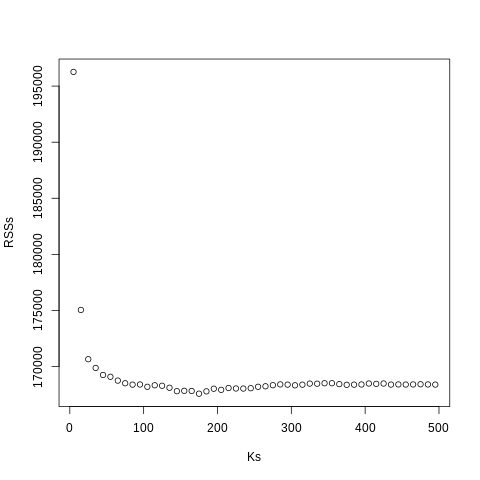

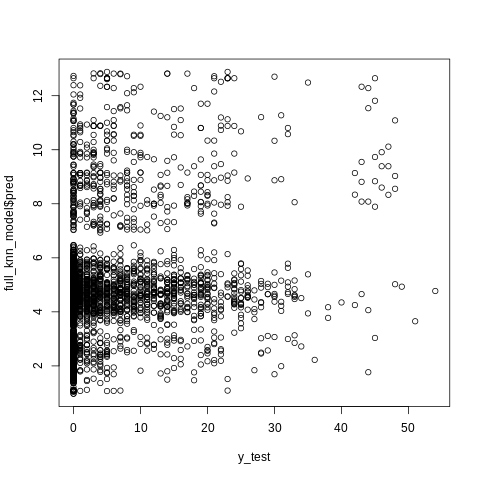

In [ ]:
%%R
# Run KNN
Ks = seq(5,500,10)
run_knn(splits_3$X_train, splits_3$y_train, splits_3$X_test, splits_3$y_test, Ks)

###Group 4: Popularity above 50


In [ ]:
%%R
data_group4 = data[data$popularity > 50,]
splits_4 = test_train_split(data_group4)
b4 = sqrt(mean((mean(data_group4$popularity) - splits_4$y_test)^2))
paste("Baseline RMSE for predicting popularity at the average is ", b4)

[1] "Baseline RMSE for predicting popularity at the average is  7.98012208850247"


[1] 9


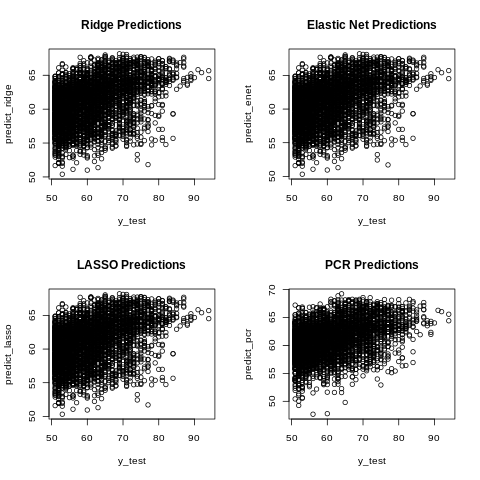

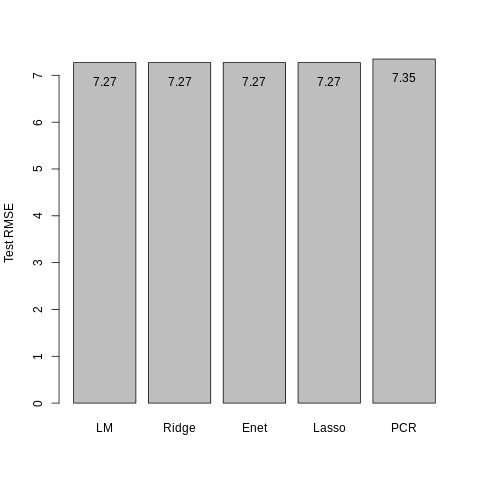

In [ ]:
%%R
lam_seq = 10^seq(-10,10,length.out =100)
fits = run_regressions(splits_4$X_train, splits_4$y_train, splits_4$X_test, splits_4$y_test, lam_seq)

[1] 295
[1] 7.873247


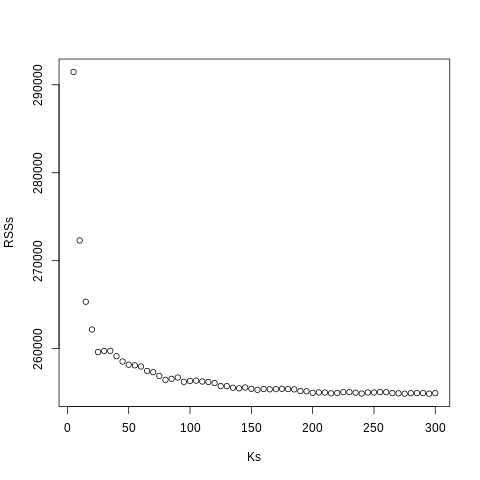

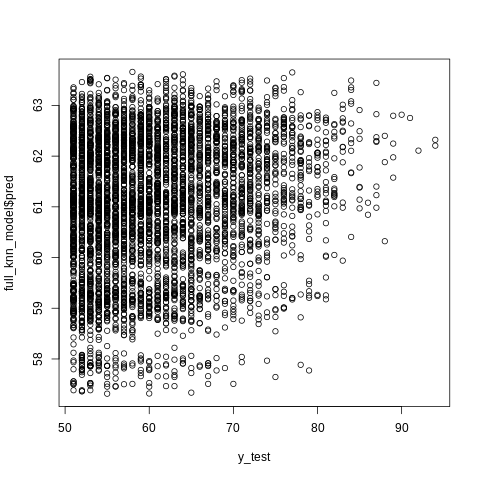

In [ ]:
%%R
# Run KNN
Ks = seq(5,300,5)
run_knn(splits_4$X_train, splits_4$y_train, splits_4$X_test, splits_4$y_test, Ks)

###Group 5: Remove Popularity of 0 & above red line


In [ ]:
%%R
data_group5 = data_group2[data_group2$popularity != 0,]
splits_5 = test_train_split(data_group5)
b5 = sqrt(mean((mean(data$popularity) - splits_5$y_test)^2))
paste("Baseline RMSE for predicting popularity at the average is ", b5)

[1] "Baseline RMSE for predicting popularity at the average is  20.7493463456048"


[1] 8


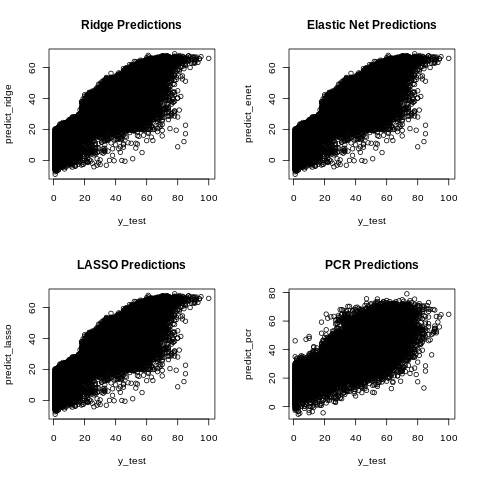

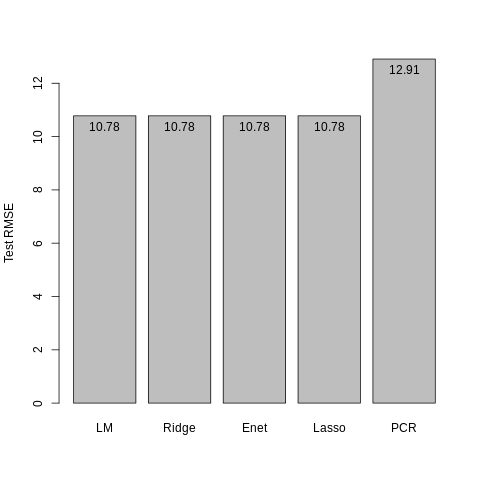

In [ ]:
%%R
lam_seq = 10^seq(-10,10,length.out =100)
fits = run_regressions(splits_5$X_train, splits_5$y_train, splits_5$X_test, splits_5$y_test, lam_seq)

[1] 5
[1] 14.47014


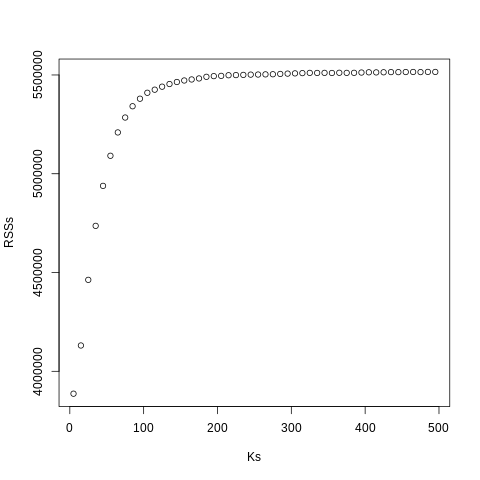

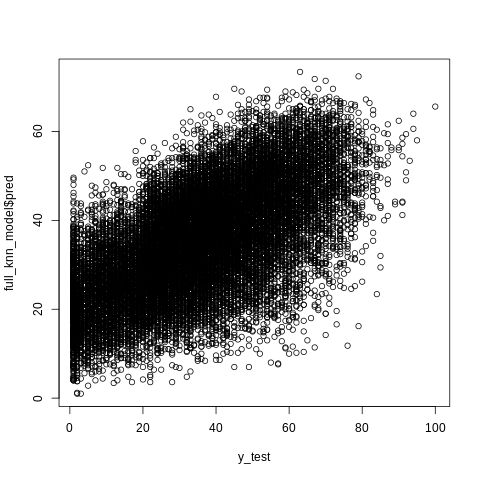

In [ ]:
%%R
# Run KNN
Ks = seq(5,500,10)
run_knn(splits_5$X_train, splits_5$y_train, splits_5$X_test, splits_5$y_test, Ks)

## Producing results for the paper

### Show that LASSO, ridge, enet and LM all perform similarly across. PCR performs worse

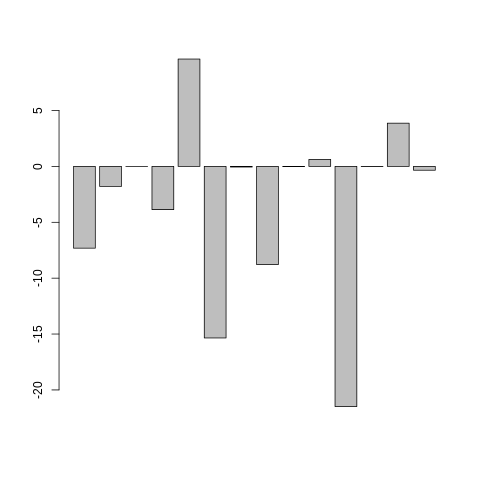

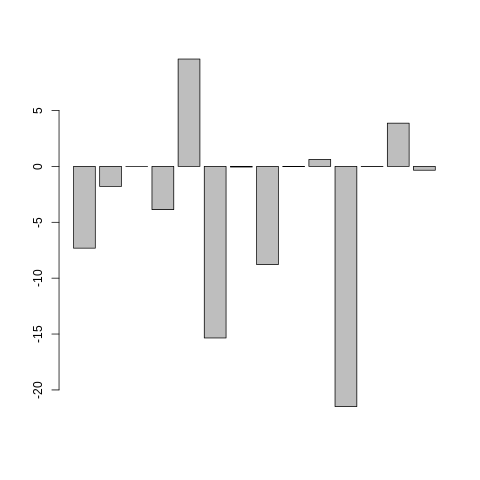

In [ ]:
%%R

#str(results1$RMSEs)
barplot(results1$fits[['lm']]$beta[1:14])
barplot(results1$fits[['lasso']]$beta[1:14])
                           

In [ ]:
%%R
sqrt(mean((predict(fits1['lm'][[1]], splits$X_test) - splits$y_test)^2))


R[write to console]: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'mean': object 'fits1' not found




Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'mean': object 'fits1' not found


### Look into the model produced by LASSO in group 2

#### Compare results with and without genre

## PCA

In [ ]:
%%R
df2 <- subset(data, select = -c(popularity, id, name, release_date,artists,artists_cleaned,year))
pr.out <- prcomp(df2, scale=T)
summary(pr.out)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.8222 1.3406 1.1617 1.07005 1.02712 0.96209 0.95405
Proportion of Variance 0.2372 0.1284 0.0964 0.08179 0.07536 0.06612 0.06501
Cumulative Proportion  0.2372 0.3656 0.4620 0.54375 0.61910 0.68522 0.75023
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.92447 0.88953 0.76694 0.72512 0.58973 0.51735 0.34844
Proportion of Variance 0.06105 0.05652 0.04201 0.03756 0.02484 0.01912 0.00867
Cumulative Proportion  0.81128 0.86780 0.90981 0.94737 0.97221 0.99133 1.00000


### Variance explained by each principal component

In [ ]:
%%R
pr.var <- pr.out$sdev^2
pve <- pr.var / sum(pr.var)
pve

 [1] 0.237179692 0.128379856 0.096400910 0.081786355 0.075355662 0.066115529
 [7] 0.065014751 0.061045425 0.056518343 0.042014440 0.037557287 0.024841623
[13] 0.019117748 0.008672379


### Plot variance explained for each principal component

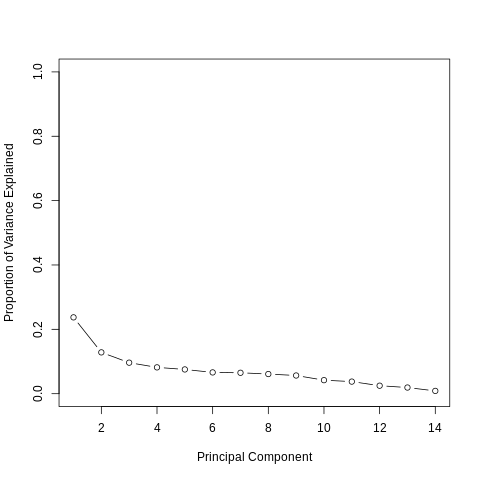

In [ ]:

%%R
plot(pve, xlab = "Principal Component",
     ylab = "Proportion of Variance Explained",
     ylim = c(0, 1), type = "b")

### Plot cumulative proportion of variance explained

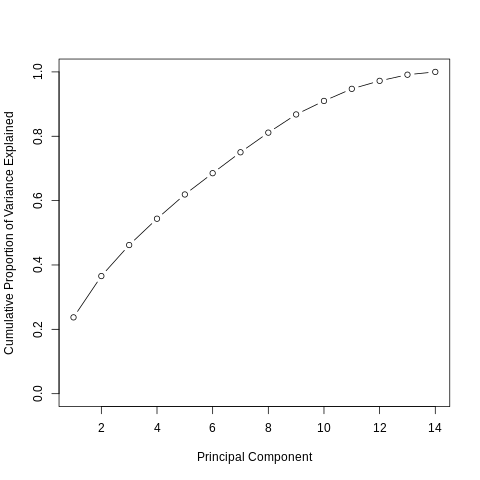

In [ ]:
%%R
plot(cumsum(pve), xlab = "Principal Component",
     ylab = "Cumulative Proportion of Variance Explained",
     ylim = c(0, 1), type = "b")

### Scaling

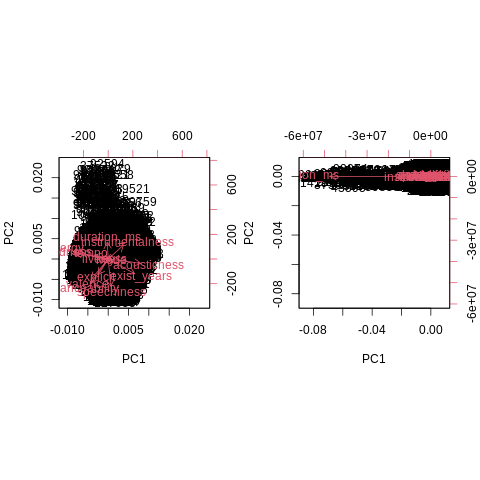

In [ ]:
%%R
colMeans(df2)
apply(df2,2, sd)
pr.with.scaling <- prcomp(df2,scale=T)
pr.without.scaling <- prcomp(df2)
par(mfrow=c(1,2))
biplot(pr.with.scaling)
biplot(pr.without.scaling)

Making the plot larger

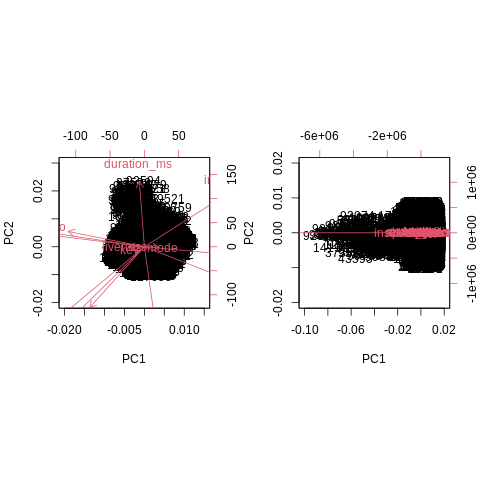

In [ ]:
%%R
pr.with.scaling <- prcomp(df2,scale=T)
pr.without.scaling <- prcomp(df2)
par(mfrow=c(1,2))
biplot(pr.with.scaling, expand=10, xlim=c(-0.020, 0.015), ylim=c(-0.02, 0.030))
biplot(pr.without.scaling, expand=10, xlim=c(-0.10, 0.02), ylim=c(-0.02, 0.02))

# Clustering

We are doing this see if the data forms clusters that predict genre based on song characteristics from specific artists. 

## Kmeans

In [ ]:
%%R
## Load the genre dataset 

print(colnames(merged_df))

## grab all the numerical data
numerical <- unlist(lapply(merged_df, is.numeric))
genreNum <- merged_df[,numerical][,1:16]

print(head(genreNum, 10))

print(colSums(merged_df[,numerical][,17:27]))

 [1] "acousticness"     "artists"          "danceability"     "duration_ms"     
 [5] "energy"           "explicit"         "id"               "instrumentalness"
 [9] "key"              "liveness"         "loudness"         "mode"            
[13] "name"             "popularity"       "release_date"     "speechiness"     
[17] "tempo"            "valence"          "year"             "artists_cleaned" 
[21] "exist_years"      "hiphop_rap"       "electro_dance"    "jazz"            
[25] "alternative"      "rock"             "other"            "pop"             
[29] "country"          "classical"        "latin"            "missing"         
[33] "genres_combined" 
   acousticness danceability duration_ms energy explicit instrumentalness key
1         0.194       0.0794      132962  0.378        0         0.846000   7
2         0.755       0.6410       22240  0.264        0         0.993000   3
3         0.604       0.6320      154680  0.352        0         0.000000   5
4         0.433 

The total number of overall genres (and hopefully clusters we are looking for is) <b>10</b>.

In [ ]:
%%R
## Using Kmeans

km.genres = kmeans(genreNum, centers = 10, nstart = 1, algorithm = "Lloyd")

# Print out the number in each cluster 1:k
cat("The amount in each cluster based off of kmeans:\n\t",sort(km.genres$size, decreasing = TRUE),"\nThe amount in each genre\n\t",sort(colSums(merged_df[,numerical][,17:27]), decreasing = TRUE))


The amount in each cluster based off of kmeans:
	 29675 28935 21791 21140 19198 15755 10793 8731 3214 209 
The amount in each genre
	 52498 38187 31540 30607 29410 26462 16735 14598 10685 10596 10328

Perhaps the data naturally clusters in some other way (years?). So let's look into different numbers of centers, thank you DataCamp!

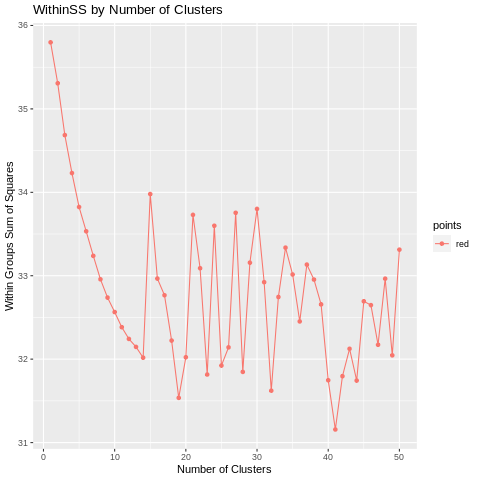

In [ ]:
%%R
# Initialize total within sum of squares error: wss
library(ggplot2)
wss <- 0

# For 1 to 20 cluster centers
for (i in 1:50) {
  km.out <- kmeans(genreNum, centers = i, nstart = 1)
  # Save total within sum of squares to wss variable
  wss[i] <- log(km.out$tot.withinss)
}

clustDF <- data.frame(cluster = 1:50, wss = wss)

#plot(1:50, wss, type = "b", 
#     xlab = "Number of Clusters", 
#     ylab = "Within groups sum of squares")

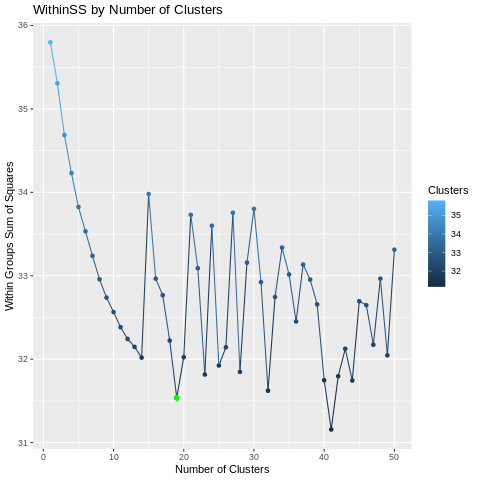

In [ ]:
%%R

# Plot total within sum of squares vs. number of clusters
ggplot(clustDF, aes(cluster, wss, colour = wss)) + geom_line() +
  geom_point() + geom_point(x = match(min(wss[0:22]),wss), y = min(wss[0:22]), colour = 'green') + labs(colour = "Clusters", x = 'Number of Clusters', 
                      y = 'Within Groups Sum of Squares', 
                      title = 'WithinSS by Number of Clusters')
  
  

#ggsave('/content/drive/Shareddrives/Data Mining Project/Imgs/clustPlot',plot = last_plot())

In [ ]:
%%R
# what is the value of k?
bestK <- match(min(wss[0:22]),wss)
print(bestK)

It seems to look like there isn't much of an "elbow" when you change the number of centers. There is a sharp drop at 15 and 20, mostly at 17, so let's explore this deeper. 

The more clusters, the better the total withinss is for each group. 

In [ ]:
%%R
kTest <- 15:20

for (k in kTest) {
    km.out <- kmeans(genreNum, centers = k, nstart = 10)
    cat("\nThe number in each cluster for", k, "centers:\n\t\t",km.out$size)
}


The number in each cluster for 15 centers:
		 5912 18873 299 26060 67 11099 97 34654 657 18761 3664 1652 30913 6672 61
The number in each cluster for 16 centers:
		 1212 97 21508 15818 67 24754 280 8504 547 25376 61 32977 14545 2818 5334 5543
The number in each cluster for 17 centers:
		 28280 29543 2252 61 1039 22498 483 257 6637 67 10851 16944 4670 20664 10909 97 4189
The number in each cluster for 18 centers:
		 998 254 19913 17228 26888 4219 14619 476 61 8539 67 23544 2005 3669 6012 21636 9216 97
The number in each cluster for 19 centers:
		 5483 17183 254 476 97 18552 3485 1962 19076 61 23498 13966 12393 7529 7906 4027 22446 67 980
The number in each cluster for 20 centers:
		 9090 256 13072 2781 1641 456 23903 11058 23241 17061 16599 5812 92 6142 869 19141 66 56 4423 3682

Let's visualie 17 clusters using two parameters. 

In [ ]:
%%R
library(ggplot2)

best.km <- kmeans(genreNum, centers = bestK, nstart = 10)


R[write to console]: Error: Continuous value supplied to discrete scale

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



RRuntimeError: ignored

## Hierarchical 

Let's look at clustering our data hierarchically - which may lead to more sense as some genres contain others. Who knows. When I run this, I get some RAM issues.

In [ ]:
%%R
# find the euclidian distance
d <- dist(genreNum, method = "euclidian")

In [ ]:
%%R

# create the hierarchial cluters
dim(as.Matrix(d))
hclust.genre <- hclust(d, method = "average")

# pray for your computer
plot(hclust.genre)

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R

# grab the cluster assignments 
# clusterAssign <- cuttree(hclust.genre)

# Exploring

## Exploring why the popularity distribution looks so weird

In [ ]:
%%R
plot(data$year, data$popularity)
m = .95
intercept = 50 - m*2020
abline(a = intercept, b = m, col = "red")
abline(h = 50, col = "blue")

# Maybe a solution is to just look at songs with pop > 50

plot(data[data$popularity > 50, "year"], data[data$popularity > 50, "popularity"], xlim = c(1920,2015))
print(nrow(data[data$popularity > 50,]))

In [ ]:
%%R

plot(data_test$year, data_test$popularity)
m = .95
intercept = 50 - m*2020
abline(a = intercept, b = m, col = "red")

In [ ]:
%%R

plot(data_train$year, data_train$popularity)
m = .95
intercept = 50 - m*2020
abline(a = intercept, b = m, col = "red")
abline(h = 50, col = "blue")

par(2,2)

In [ ]:

%%R
# What is going on with these songs under this red line? 
low_pop = data[data$year*m + intercept > data$popularity,c("name","popularity","year")]


In [ ]:
%%R
year_count = as.data.frame(table(factor(data$year, 1920:2021)))
year_count_lpop = as.data.frame(table(factor(data[data$year*m + intercept > data$popularity,"year"], 1920:2021)))
year_count_50pop = as.data.frame(table(factor(data[data$popularity > 50,"year"], 1920:2021)))
plot(year_count$Var1, year_count$Freq, main = "Songs per year")
abline(h=2000, col = "red")
plot(year_count_lpop$Var1, year_count_lpop$Freq/year_count$Freq, main = "Proportion of songs under the weird threshold per year")
abline(h=.5, col = "red")
plot(year_count_lpop$Var1, year_count_50pop$Freq, main = "Number of songs per year with pop > 50")


# Linear Regression

In [ ]:
%%R

fit1 <- lm(popularity ~ acousticness + duration_ms + energy + instrumentalness + liveness + loudness + speechiness + tempo + valence + key + mode + exist_years, data=data_train)
summary(fit1)
plot(predict(fit1), data_train$popularity)
plot(predict(fit1, data_test), data_test$popularity)

MRSE_train = sqrt((mean((predict(fit1) - data_train$popularity)^2)))
MRSE_test = sqrt((mean((predict(fit1, data_test) - data_test$popularity)^2)))
print(MRSE_train)
print(MRSE_test)

In [ ]:
%%R
colnames(data)

In [ ]:
%%R
coefficients(fit1)

In [ ]:
%%R
confint(fit1, level=0.95)

see if data_w_genres has null value

In [ ]:
%%R
data_w_genres[2:6,16]


liveness and popularity

In [ ]:
%%R
genres_clean <- data_w_genres[!(is.na(data_w_genres$genres) | data_w_genres$genres==""), ]
plot(genres_clean$liveness,genres_clean$popularity,xlim=c(0,1),ylim=c(0,100))


danceability and popularity

In [ ]:
%%R
plot(genres_clean$danceability,genres_clean$popularity,xlim=c(0,1),ylim=c(0,100))

acousticness and popularity

In [ ]:
%%R
range(genres_clean$acousticness)
plot(genres_clean$acousticness,genres_clean$popularity,xlim=c(0,1),ylim=c(0,100))

duration and poularity

In [ ]:
%%R
range(genres_clean$duration_ms)
plot(genres_clean$duration_ms,genres_clean$popularity,xlim=c(8000,5000000),ylim=c(0,100))

instrumentalness and popularity

In [ ]:
%%R
range(genres_clean$instrumentalness)
plot(genres_clean$instrumentalness,genres_clean$popularity,xlim=c(0,1),ylim=c(0,100))


loudness and popularity

In [ ]:
%%R
range(genres_clean$loudness)
plot(genres_clean$loudness,genres_clean$popularity,xlim=c(-60,4),ylim=c(0,100))

speechiness and popularity

In [ ]:
%%R
range(genres_clean$speechiness)
plot(genres_clean$speechiness,genres_clean$popularity,xlim=c(0,1),ylim=c(0,100))

### Correlation chart

# 新段落

# 新段落

In [ ]:
%%R
nonnumeric_cols = unlist(lapply(data,is.numeric))
#Extracting numeric columns to check for correlation
head(data[,nonnumeric_cols])

       acousticness danceability duration_ms energy explicit instrumentalness
110897        0.194       0.0794      132962  0.378        0           0.8460
24051         0.755       0.6410       22240  0.264        0           0.9930
43461         0.604       0.6320      154680  0.352        0           0.0000
104839        0.433       0.4200      198773  0.251        0           0.0000
86701         0.527       0.7710      304627  0.800        0           0.0289
88114         0.752       0.7440      177969  0.545        0           0.0000
       key liveness loudness mode popularity speechiness   tempo valence year
110897   7   0.1000  -12.947    1          0      0.0555 172.357  0.0388 1936
24051    3   0.5050  -22.449    1          0      0.0447  78.117  0.2670 1943
43461    5   0.3710  -16.204    1          0      0.0678 100.022  0.8050 1946
104839   7   0.2130  -16.082    1         43      0.1000 155.784  0.7470 1992
86701    0   0.0929   -5.214    0         36      0.1310 159.985

In [ ]:
%%R
install.packages('corrplot')
library(corrplot)
corrplot(cor(data[,nonnumeric_cols]), type = 'upper')

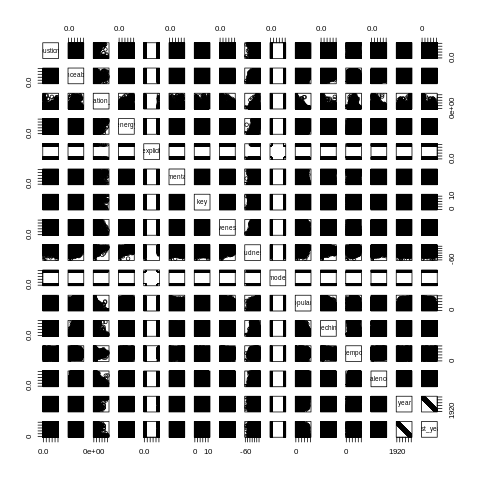

In [ ]:
%%R
pairs(data[,sapply(data, is.numeric)])

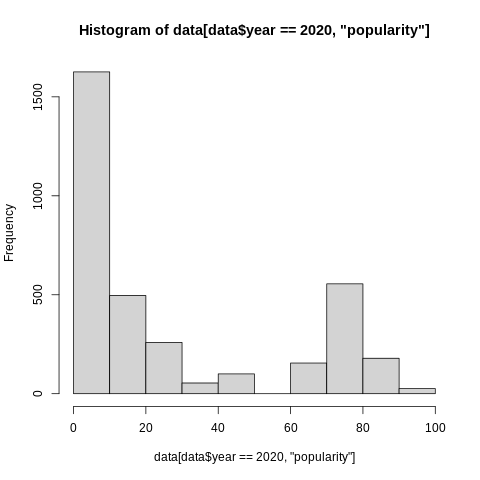

In [ ]:
%%R
hist(data[data$year == 2020, "popularity"])

In [ ]:
%%R
print(which(data$year < 1960 & data$popularity > 80))
print(data[7263,])

which(data$year == 2000 & data$popularity == 85)
print(data[15863,])

[1] 66663 67948 76101 76119
      acousticness       artists danceability duration_ms energy explicit
66509        0.939 ['Bob Dylan']        0.335      193093  0.205        0
                          id instrumentalness key liveness loudness mode
66509 4nBjbqj7nKd7Rsa7HJ3VtX         6.25e-05   0    0.104  -10.869    1
                      name popularity release_date speechiness   tempo valence
66509 All the Tired Horses         37   1970-06-08       0.032 135.725   0.254
      year artists_cleaned exist_years
66509 1970       Bob Dylan          51
      acousticness          artists danceability duration_ms energy explicit
70202        0.223 ['Public Enemy']        0.783      383627  0.808        1
                          id instrumentalness key liveness loudness mode
70202 4blNCZOOKSi1JCbZZmqEkJ                0   6    0.325  -11.828    1
                                  name popularity release_date speechiness
70202 Black Steel In The Hour Of Chaos         37   1988-06-28     

In [ ]:
%%R
data[data$name == 'Thriller',]

       acousticness             artists danceability duration_ms energy
123922      0.00734    ['Fall Out Boy']        0.375      209720  0.901
158072      0.08160 ['Michael Jackson']        0.764      358053  0.887
       explicit                     id instrumentalness key liveness loudness
123922        0 07kBp5VuebubsozpQd3nyK         1.68e-06   2    0.315   -3.388
158072        0 7azo4rpSUh8nXgtonC6Pkq         1.10e-04  11    0.847   -3.726
       mode     name popularity release_date speechiness   tempo valence year
123922    1 Thriller         52   2007-01-01      0.1060 178.895   0.327 2007
158072    1 Thriller         69   1982-11-30      0.0744 118.427   0.720 1982
       artists_cleaned exist_years
123922    Fall Out Boy          14
158072 Michael Jackson          39


In [ ]:
%%R
data_o[data_o$name == 'Thriller',]

      valence year acousticness             artists danceability duration_ms
12025   0.813 1982      0.08550 ['Michael Jackson']        0.773      357267
12064   0.783 1982      0.03180 ['Michael Jackson']        0.771      357800
17598   0.799 2009      0.09130 ['Michael Jackson']        0.776      357493
37883   0.720 2017      0.08160 ['Michael Jackson']        0.764      358053
70182   0.787 1995      0.12500 ['Michael Jackson']        0.770      357467
72453   0.327 2007      0.00734    ['Fall Out Boy']        0.375      209720
      energy explicit                     id instrumentalness key liveness
12025  0.859        0 3S2R0EVwBSAVMd5UMgKTL0         1.80e-04  11    0.914
12064  0.687        0 2LlQb7Uoj1kKyGhlkBf9aC         2.25e-04  11    0.890
17598  0.857        0 1D9KEXIrlmPUkMTdYzqgX4         1.64e-04  11    0.918
37883  0.887        0 7azo4rpSUh8nXgtonC6Pkq         1.10e-04  11    0.847
70182  0.813        0 1A1eQ01CbtSZeyxj6489IS         1.97e-04  11    0.889
72453  0.90

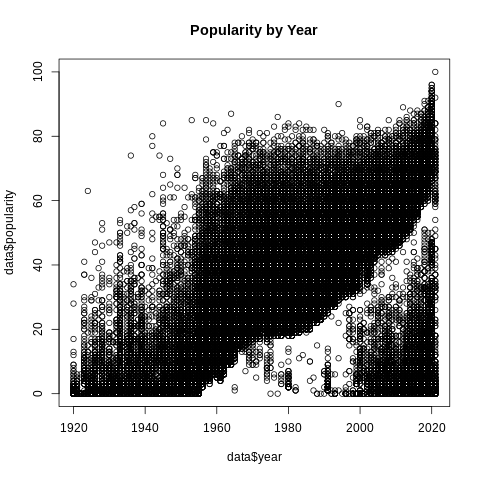

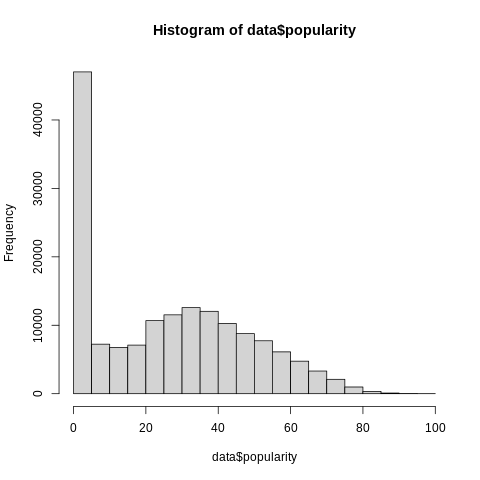

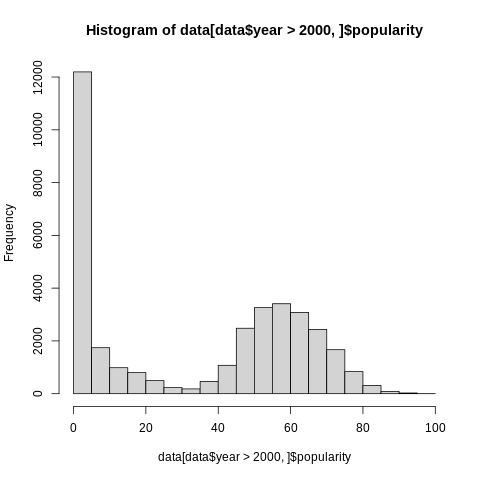

In [ ]:
%%R
plot(data$year,data$popularity,xlim = c(1920,2021), ylim = c(0,100))
title('Popularity by Year')
hist(data$popularity)
hist(data[data$year > 2000,]$popularity)

[1] 13563


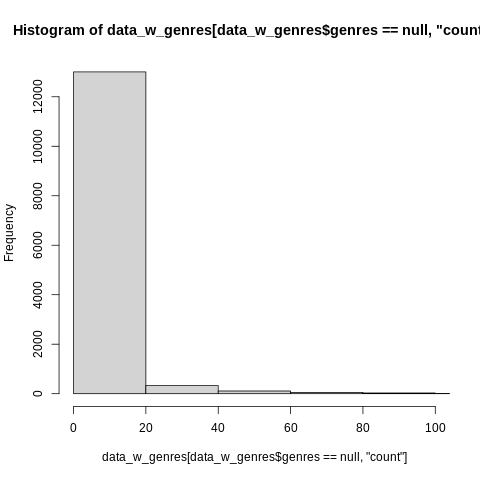

In [ ]:
%%R
null = data_w_genres$genres[2]
print(sum(data_w_genres$genres == null))
hist(data_w_genres[data_w_genres$genres == null,"count"], breaks = 100, xlim = c(0,100))

[1] 13563
[1] 794
[1] 5558


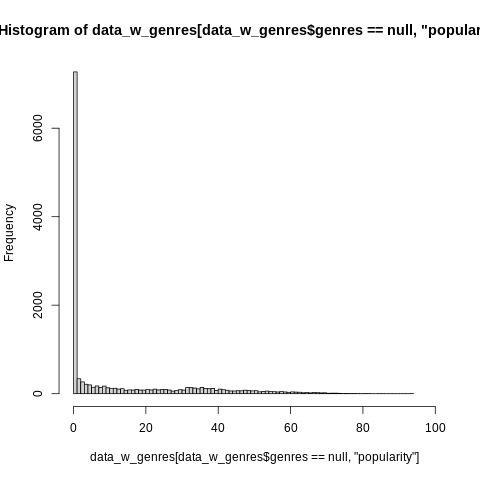

In [ ]:
%%R
null = data_w_genres$genres[2]
print(sum(data_w_genres$genres == null))
hist(data_w_genres[data_w_genres$genres == null,"popularity"], breaks = 100, xlim = c(0,100))
null_genre = data_w_genres[data_w_genres$genres == null,]

print(nrow(null_genre[null_genre$popularity > 50,]))
print(nrow(data_w_genres[data_w_genres$popularity > 50,]))

In [ ]:
%%R
data_w_genres[data_w_genres$artists == 'Michael Jackson',"popularity"]

[1] 47.85337


In [ ]:
%%R

df <- data[data$artists_cleaned == 'Michael Jackson',c("name","year","popularity")]

ordered = order(data[data$artists_cleaned == 'Michael Jackson',c("name","year","popularity")]$year)

mean(df$popularity)

[1] 47.81967


In [ ]:
%%R
#install.packages('sets')


NULL


In [ ]:
%%R


UsageError: %%R is a cell magic, but the cell body is empty. Did you mean the line magic %R (single %)?
